In [131]:
# Pip install
!pip install pyannote.audio
!pip install pyloudnorm
!pip install kaggle

In [132]:
!kaggle datasets list

ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
rakeshkapilavai/extrovert-vs-introvert-behavior-data              Extrovert vs. Introvert Behavior Data                    15392  2025-05-21 04:26:52.443000           4056         95  1.0              
adilshamim8/social-media-addiction-vs-relationships               Students' Social Media Addiction                          7851  2025-05-10 14:38:02.713000          10156        148  1.0              
atomicd/retail-store-inventory-and-demand-forecasting             Retail Store Inventory and Demand Forecasting          1424032  2025-05-21 10:51:54.783000           1867         27  1.0     

In [133]:
# Kaggle datasets
# !kaggle datasets download -d mfekadu/english-multispeaker-corpus-for-voice-cloning --unzip -p ./data

In [134]:
# Imports
import IPython.display as ipd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pyloudnorm as pyln
from scipy import signal
import torch

In [135]:
model, utils = torch.hub.load(
    repo_or_dir="snakers4/silero-vad",
    model="silero_vad",
    force_reload=True
)
get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to C:\Users\Samurai/.cache\torch\hub\master.zip


In [136]:
wave_pathes = glob("./data/VCTK-Corpus/VCTK-Corpus/wav48/*/*.wav", recursive=True)

In [137]:
def visualize_vad_comparison(audio_wave, ref_vad_segments, test_vad_segments):
    plt.figure(figsize=(12, 6))
    plt.plot(audio_wave, label="Audio Signal", linewidth=1)

    for i, ref_seg in enumerate(ref_vad_segments):
        plt.axvspan(
            ref_seg["start"], ref_seg["end"],
            color="lightgray", alpha=0.3,
            label="Reference VAD" if i == 0 else None
        )

    for j, test_seg in enumerate(test_vad_segments):
        plt.axvspan(
            test_seg["start"], test_seg["end"],
            color="salmon", alpha=0.3,
            label="Proposed VAD" if j == 0 else None
        )

    plt.title("Comparison of VAD Outputs")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [138]:
def plot_feature_dynamics(
    metric_name, data_series, speech_marks=None,
    threshold=None, win_size=640, hop_length=160
):
    plt.figure(figsize=(12, 6))
    x_indices = range(len(data_series))
    plt.plot(x_indices, data_series, label="Feature Trace", color="blue")

    if speech_marks:
        for idx, segment in enumerate(speech_marks):
            seg_start = max((segment["start"] - win_size) // hop_length + 1, 0)
            seg_end = max((segment["end"] - win_size) // hop_length + 1, 0)
            plt.axvspan(
                seg_start, seg_end, color="orange", alpha=0.3,
                label="Detected Speech" if idx == 0 else None
            )

    if threshold is not None:
        plt.axhline(
            y=threshold, xmin=0, xmax=len(data_series) - 1,
            color="darkred", linestyle="--",
            label=f"Threshold = {threshold}"
        )

    if metric_name == "energy":
        plt.title("Frame-wise Energy")
        plt.ylabel("Normalized Energy")
    elif metric_name == "zcr":
        plt.title("Zero-Crossing Rate (ZCR)")
        plt.ylabel("ZCR (Normalized)")
    else:
        plt.title(f"{metric_name.title()} Feature Trend")
        plt.ylabel("Scaled Value")

    plt.xlabel("Frame Number")
    plt.legend()
    plt.grid(visible=True)
    plt.tight_layout()
    plt.show()


In [139]:
def zero_crossings(segment):
    return np.sum(np.abs(np.sign(segment[1:]) - np.sign(segment[:-1]))) // 2 + 1

In [140]:
def frame_energy(segment):
    return np.sqrt(np.sum(segment ** 2))

In [141]:
def normalize_loudness(sample, sample_rate, level=-9.0):
  meter = pyln.Meter(sample_rate)
  loudness = meter.integrated_loudness(sample)
  return pyln.normalize.loudness(sample, loudness, level)

In [142]:
def normalize_range(series):
    series = np.array(series)
    low, high = np.min(series), np.max(series)
    return ((series - low) / (high - low)).tolist()

In [143]:
def compute_signal_descriptors(waveform, frame_len=640, hop_len=160):
    energy_list = []
    zcr_list = []

    for pos in range(0, len(waveform) - frame_len, hop_len):
        frame = waveform[pos : pos + frame_len]
        energy_list.append(frame_energy(frame))
        zcr_list.append(zero_crossings(frame))

    energy_scaled = normalize_range(energy_list)
    zcr_scaled = normalize_range(zcr_list)

    return energy_scaled, zcr_scaled

In [144]:
def detect_speech_segments(waveform, sample_rate):
    frame_size = sample_rate * 40 // 1000
    hop_size = sample_rate * 10 // 1000

    energy_profile, zcr_profile = compute_signal_descriptors(waveform, frame_size, hop_size)
    energy_threshold = 0.01
    zcr_threshold = 1.0

    speech_segments = [
        {
            "start": i * hop_size,
            "end": i * hop_size + frame_size
        }
        for i, (energy, zcr) in enumerate(zip(energy_profile, zcr_profile))
        if energy > energy_threshold and zcr < zcr_threshold
    ]

    return speech_segments, energy_profile, zcr_profile

In [145]:
def merge_speech_chunks(chunks, sample_rate):
    if not chunks:
        return []

    merged = []
    intervals = [chunk.copy() for chunk in chunks]

    min_len = sample_rate * 0.09
    max_gap = sample_rate * 0.2

    for idx in range(len(intervals) - 1):
        current_seg = intervals[idx]
        next_seg = intervals[idx + 1]

        pause = next_seg["start"] - current_seg["end"]
        duration = current_seg["end"] - current_seg["start"]

        if pause > max_gap:
            if duration >= min_len:
                merged.append(current_seg)
        else:
            next_seg["start"] = current_seg["start"]

    final_seg = intervals[-1]
    final_duration = final_seg["end"] - final_seg["start"]
    if final_duration >= min_len:
        merged.append(final_seg)

    return merged

In [146]:
def run_filter(wave, sample_rate, filter_type, filter_mode=None):
    if filter_type == "wiener":
        return signal.wiener(wave, mysize=7)

    cutoff = 300 if filter_mode == "highpass" else 3400
    normalized_cutoff = cutoff / (0.5 * sample_rate)

    if filter_type == "butterworth":
        b, a = signal.butter(3, normalized_cutoff, btype=filter_mode, output='ba')
    elif filter_type == "chebyshev1":
        b, a = signal.cheby1(4, 0.5, normalized_cutoff, btype=filter_mode, output='ba')
    elif filter_type == "chebyshev2":
        b, a = signal.cheby2(1, 5, normalized_cutoff, btype=filter_mode, output='ba')
    elif filter_type == "elliptic":
        b, a = signal.ellip(5, 2.4, 7, normalized_cutoff, btype=filter_mode, output='ba')
    elif filter_type == "bessel":
        b, a = signal.bessel(1, normalized_cutoff, btype=filter_mode, output='ba')
    else:
        raise ValueError(f"Unknown filter type: {filter_type}")

    return signal.lfilter(b, a, wave)


In [147]:
def run_voice_detection(path):
    audio, rate = librosa.load(path, sr=16000)
    prepped = normalize_loudness(audio, rate)
    filtered = run_filter(prepped, rate, "butterworth", "highpass")
    filtered = run_filter(filtered, rate, "bessel", "lowpass")
    filtered = run_filter(filtered, rate, "wiener")
    raw_regions, _, _ = detect_speech_segments(filtered, rate)
    return merge_speech_chunks(raw_regions, rate)

In [148]:
import requests

url = "https://www.vibrationdata.com/Kawai_Major_Third_A_C_sharp.mp3"
save_path = "data/piano.mp3"

headers = {
    "User-Agent": "Mozilla/5.0"
}

response = requests.get(url, headers=headers)

with open(save_path, "wb") as f:
    f.write(response.content)

print("Download complete.")


Download complete.


In [149]:
import os

sample_file = "piano.mp3"

if not os.path.exists(sample_file):
    print(f"Файл {sample_file} не знайдено!")
else:
    print(f"Файл {sample_file} знайдено.")

Файл piano.mp3 знайдено.


In [150]:
import librosa

wav, sr = librosa.load(sample_file, sr=None)


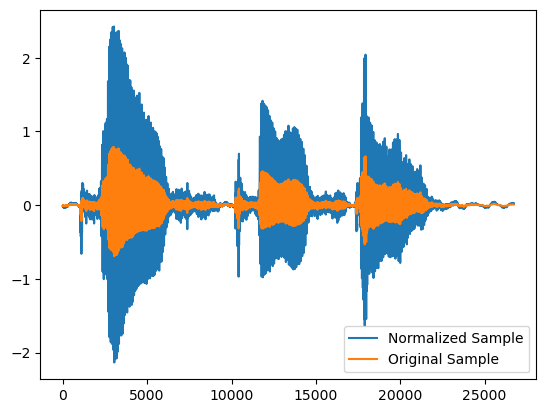

In [151]:
sample, sample_rate = librosa.load(sample_file, sr=16000)
normalized_sample = normalize_loudness(sample, sample_rate)
plt.plot(normalized_sample, label="Normalized Sample")
plt.plot(sample, label="Original Sample")
plt.legend()
plt.show()

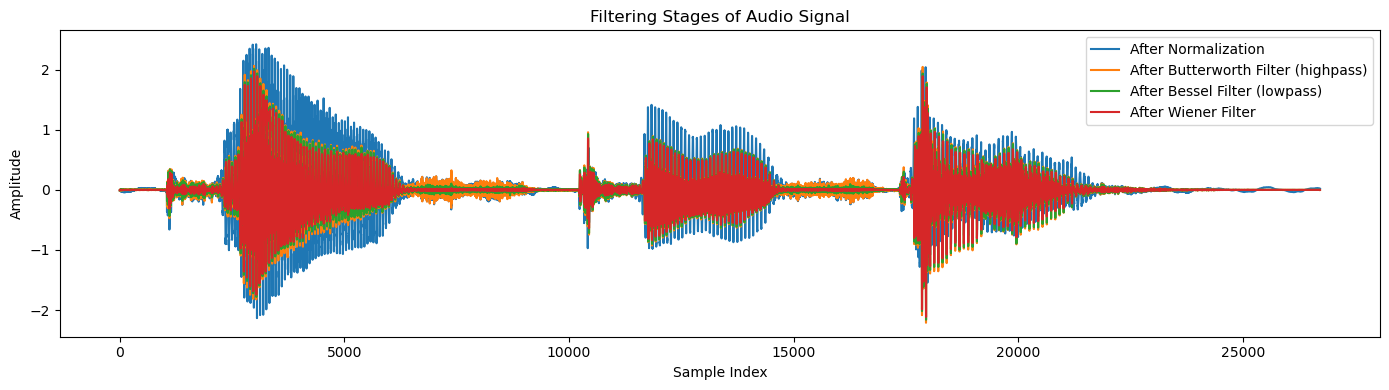

In [152]:
plt.figure(figsize=(14, 4))
plt.plot(normalized_sample, label="After Normalization")

step1 = run_filter(normalized_sample, sample_rate, "butterworth", "highpass")
plt.plot(step1, label="After Butterworth Filter (highpass)")

step2 = run_filter(step1, sample_rate, "bessel", "lowpass")
plt.plot(step2, label="After Bessel Filter (lowpass)")

step3 = run_filter(step2, sample_rate, "wiener")
plt.plot(step3, label="After Wiener Filter")

plt.legend()
plt.title("Filtering Stages of Audio Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [153]:
audio_path = "piano.mp3"


audio = read_audio(audio_path)
sample_rate = 16000
if isinstance(audio, torch.Tensor):
  audio = audio.numpy()

audio_tensor = torch.from_numpy(audio).float()
silero_speech_timestamps = get_speech_timestamps(audio_tensor, model, sampling_rate=sample_rate)
rough_speech_segments, energies, zcrs = detect_speech_segments(audio, sample_rate)

print(f"Number of speech timestamps (before smoothing): {len(rough_speech_segments)}")

Number of speech timestamps (before smoothing): 150


In [154]:
# plot_feature_dynamics(audio, silero_speech_timestamps, rough_speech_segments)


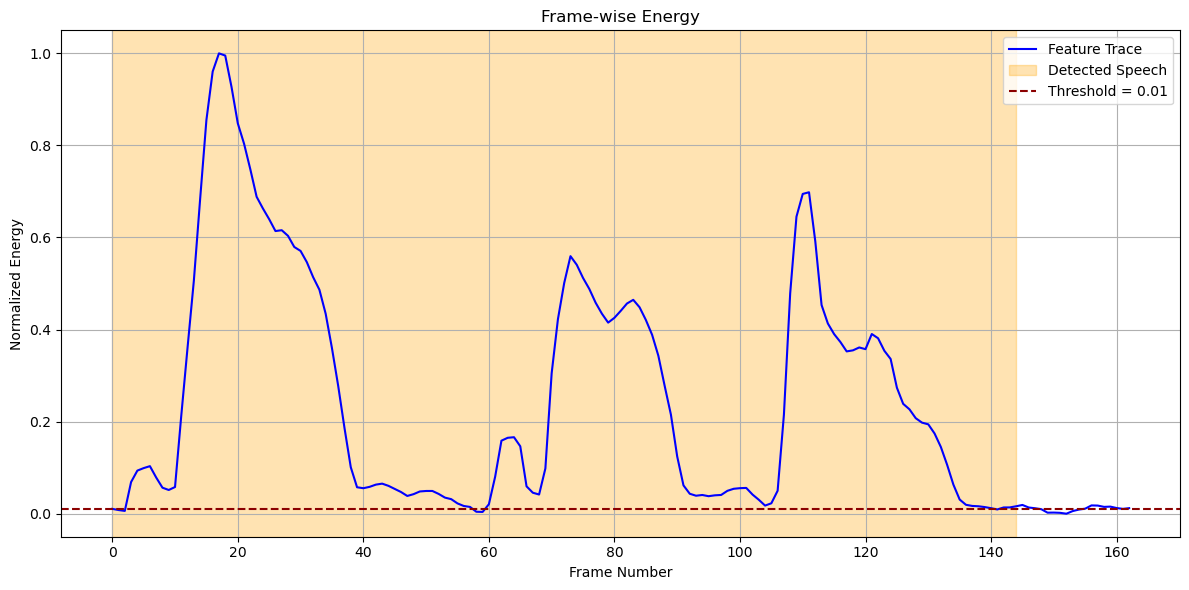

In [155]:
plot_feature_dynamics("energy", energies, silero_speech_timestamps, 0.01)


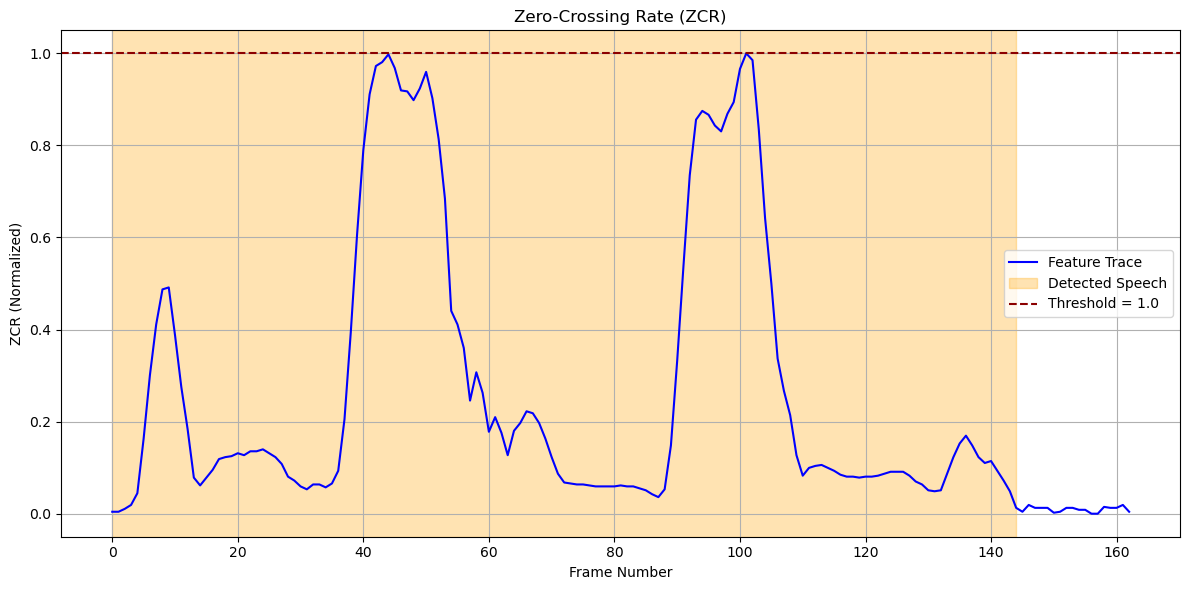

In [156]:
plot_feature_dynamics("zcr", zcrs, silero_speech_timestamps, 1.0)


In [157]:
smoothed_segments = merge_speech_chunks(rough_speech_segments, sample_rate)

print(f"Silero VAD speech timestamps: {silero_speech_timestamps}")
print(f"Custom VAD speech segments: {smoothed_segments}")

# plot_feature_dynamics(audio, silero_speech_timestamps, smoothed_segments)

final_audio = collect_chunks(smoothed_segments, audio_tensor)
save_audio("piano.mp3", final_audio)

Silero VAD speech timestamps: [{'start': 544, 'end': 23520}]
Custom VAD speech segments: [{'start': 0, 'end': 26560}]


In [158]:
ipd.Audio(sample_file)

In [159]:
ipd.Audio("piano.mp3")

In [160]:
import warnings
warnings.filterwarnings("ignore")

from pyannote.core import Annotation, Segment
from pyannote.metrics.detection import DetectionErrorRate

def build_annotation(segments, time_divisor=10000):
    annotation = Annotation()
    for s in segments:
        start = s["start"] / time_divisor
        end = s["end"] / time_divisor
        annotation[Segment(start, end)] = "SPEECH"
    return annotation

def evaluate_vad_performance(file_paths, model, vad_function, reference_function, limit=None):
    der = DetectionErrorRate()
    files_to_process = file_paths[:limit] if limit else file_paths

    for idx, path in enumerate(files_to_process, start=1):
        audio = read_audio(path)
        reference_segs = reference_function(audio, model)
        hypothesis_segs = vad_function(path)

        reference = build_annotation(reference_segs)
        hypothesis = build_annotation(hypothesis_segs)

        _ = der(reference, hypothesis)

        print(f"[{idx}/{len(files_to_process)}] Processed: {path} — Current DER: {abs(der) * 100:.2f}%")

    return abs(der)

overall_error = evaluate_vad_performance(
    wave_pathes,
    model=model,
    vad_function=run_voice_detection,
    reference_function=get_speech_timestamps,
    limit=1000
)

print(f"Detection Error Rate: {overall_error * 100:.1f}%")


[1/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_001.wav — Current DER: 4.81%
[2/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_002.wav — Current DER: 3.53%
[3/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_003.wav — Current DER: 11.48%
[4/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_004.wav — Current DER: 10.66%
[5/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_005.wav — Current DER: 10.61%
[6/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_006.wav — Current DER: 9.99%
[7/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_007.wav — Current DER: 10.19%
[8/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_008.wav — Current DER: 10.49%
[9/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_009.wav — Current DER: 11.59%
[10/1000] Processed: ./data/VCTK-Corpus/VCTK-Corpus/wav48\p225\p225_010.wav — Current DER: 11.75%
[11/1000] Processed: ./data/VCTK